In [1]:
import numpy as np
import os 
import pandas as pd
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torch.utils.data as Data
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
# define utility classes and functions 
# create data loader 
class Dataset(Data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        label = self.y[index]
        feature = self.X[index]

        return feature, label

# create function that evaluate validation and testing set performance 
def acc(DataLoader, Model):
    actual, predicted = [], []
    for data in DataLoader:
        d, l = data
        actual.append(l.item())
        output = Model(d.float())
        _, p = torch.max(output, 1)
        predicted.append(p.item())
    f1, acc = f1_score(actual, predicted, average='micro'), accuracy_score(actual, predicted)
    return actual, predicted, f1, acc

def plot_confusion_matrix(y_true, y_pred, classes,title,cmap=plt.cm.Blues, normalize=False):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes)
    plt.xticks(np.arange(cm.shape[1]),fontsize=18)
    plt.yticks(np.arange(cm.shape[0]),fontsize=18)
    ax.set_title(title,fontweight="bold", size=18) # Title
    ax.set_ylabel('True label', fontsize = 18) # Y label
    ax.set_xlabel('Predicted label', fontsize = 18) # X label

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [3]:
# os.chdir(r'./project')
X_test = np.load('./project/X_test.npy')
y_test = np.load('./project/y_test.npy')
person_train_valid = np.load('./project/person_train_valid.npy')
X_train_valid = np.load('./project/X_train_valid.npy')
y_train_valid = np.load('./project/y_train_valid.npy')
person_test = np.load('./project/person_test.npy')

Text(0,0.5,'frequency')

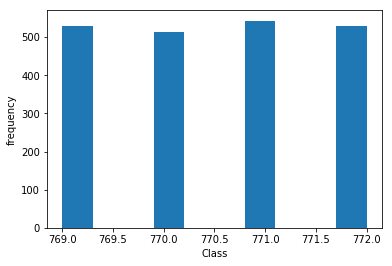

In [4]:
plt.hist(y_train_valid)
plt.xlabel('Class')
plt.ylabel('frequency')

In [5]:
# train-valid split and transform to torch tensor 
transform = transforms.ToTensor()

# label encoder
le = preprocessing.LabelEncoder()
le.fit(y_train_valid)
y_train_valid_le = le.transform(y_train_valid)
y_test_le = le.transform(y_test)

# train-test split 
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid_le, train_size = 0.8)


params = {'batch_size': 64, 'shuffle': True}
train_loader = Data.DataLoader(Dataset(X=X_train, y=y_train), **params)
train_val_loader = Data.DataLoader(Dataset(X = X_train_valid, y = y_train_valid_le))
valid_loader = Data.DataLoader(Dataset(X=X_valid, y=y_valid))
test_loader = Data.DataLoader(Dataset(X=X_test, y=y_test_le))

In [6]:
y_train[6]

2

# Data Visualization

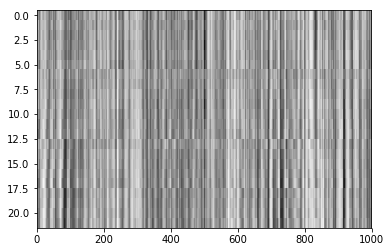

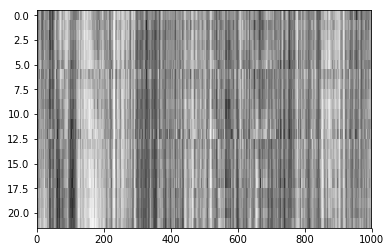

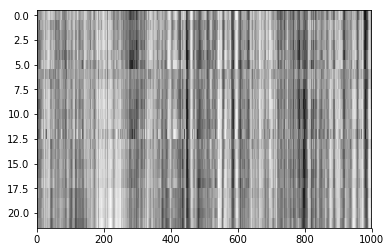

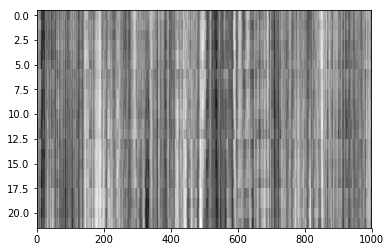

In [7]:
# class 0
plt.imshow(X_train[6], aspect='auto', cmap='Greys')
plt.show()

# class 1
plt.imshow(X_train[2], aspect='auto', cmap='Greys')
plt.show()

# class 2
plt.imshow(X_train[4], aspect='auto', cmap='Greys')
plt.show()

# class 3
plt.imshow(X_train[5], aspect='auto', cmap='Greys')
plt.show()



# CNN

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
# simple 1d cnn
class CNN_trail(nn.Module):
    def __init__(self):
        super(CNN_trail, self).__init__()
        self.conv1 = nn.Conv1d(in_channels = 22, out_channels = 128, kernel_size = 7)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.AvgPool1d(3)

        self.conv2 = nn.Conv1d(in_channels = 128, out_channels = 512, kernel_size = 7)
        self.bn2 = nn.BatchNorm1d(512)
        self.pool2 = nn.AvgPool1d(3)

        self.dropout = nn.Dropout(0.7)
        self.fc1 = nn.Linear(55296, 4)


    def forward(self, x):
        x = x.to(device)
        # layer 1
        x = self.pool1(self.dropout(F.relu(self.bn1(self.conv1(x)))))

        # layer 2
        x = self.pool2(self.dropout(F.relu(self.bn2(self.conv2(x)))))

        # fc layer
        x = x.view(-1, 55296)
        x = self.fc1(x)

        return x

In [10]:
net0 = CNN_trail()
net0.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net0.parameters(), lr = 0.0001, momentum=0.9, weight_decay = 0.1)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

for epoch in range(500):
    running_loss = 0.0

    for mini_batch, d in enumerate(train_loader,0):
        # retreive data from data loader 
        inputs, labels = d
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)

        # train
        optimizer.zero_grad()
        outputs = net0(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print
        running_loss += loss.item()
        if mini_batch % 10 == 9:
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            _, _, _, val_acc = acc(valid_loader, net0)
            print('[epoch %d, mini-batch %5d] loss: %.3f, train_acc: %d %%, val_acc: %d %%' %
                  (epoch + 1, mini_batch + 1, running_loss / 10, 100 * correct / len(labels), 100 * val_acc))
            running_loss = 0.0

val_label0, val_predict0, val_f10, val_acc0 = acc(valid_loader, net0)
test_label0, test_predict0, test_f10, test_acc0 = acc(test_loader, net0)
print('Training complete! Val acc: %d %%'%(val_acc0*100))
print('Training complete! Test acc: %d %%'%(test_acc0*100))

n_acc: 95 %, val_acc: 61 %
[epoch 366, mini-batch    20] loss: 0.476, train_acc: 95 %, val_acc: 59 %
[epoch 367, mini-batch    10] loss: 0.484, train_acc: 85 %, val_acc: 59 %
[epoch 367, mini-batch    20] loss: 0.459, train_acc: 92 %, val_acc: 60 %
[epoch 368, mini-batch    10] loss: 0.478, train_acc: 90 %, val_acc: 60 %
[epoch 368, mini-batch    20] loss: 0.483, train_acc: 90 %, val_acc: 61 %
[epoch 369, mini-batch    10] loss: 0.471, train_acc: 93 %, val_acc: 60 %
[epoch 369, mini-batch    20] loss: 0.474, train_acc: 90 %, val_acc: 60 %
[epoch 370, mini-batch    10] loss: 0.464, train_acc: 87 %, val_acc: 58 %
[epoch 370, mini-batch    20] loss: 0.499, train_acc: 85 %, val_acc: 60 %
[epoch 371, mini-batch    10] loss: 0.470, train_acc: 93 %, val_acc: 60 %
[epoch 371, mini-batch    20] loss: 0.463, train_acc: 95 %, val_acc: 58 %
[epoch 372, mini-batch    10] loss: 0.484, train_acc: 92 %, val_acc: 60 %
[epoch 372, mini-batch    20] loss: 0.492, train_acc: 92 %, val_acc: 60 %
[epoch 373,

In [11]:
# simple 1d cnn
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        self.conv1 = nn.Conv1d(in_channels = 22, out_channels = 64, kernel_size = 3)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(3)

        self.conv2 = nn.Conv1d(in_channels = 64, out_channels = 128, kernel_size = 7)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(3)

        self.conv3 = nn.Conv1d(in_channels = 128, out_channels = 256, kernel_size = 7)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(3)

        self.conv4 = nn.Conv1d(in_channels = 256, out_channels = 512, kernel_size = 15)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.AvgPool1d(3)

        self.dropout = nn.Dropout(0.6)
        self.fc1 = nn.Linear(3072, 4)

    def forward(self, x):
        x = x.to(device)
        # layer 1
        x = self.pool1(self.dropout(F.relu(self.bn1(self.conv1(x)))))

        # layer 2
        x = self.pool2(self.dropout(F.relu(self.bn2(self.conv2(x)))))

        # layer 3
        x = self.pool3(self.dropout(F.relu(self.bn3(self.conv3(x)))))

        # layer 4
        x = self.pool4(self.dropout(F.relu(self.bn4(self.conv4(x)))))

        # fc layer
        x = x.view(-1, 3072)
        x = self.fc1(x)

        return x

In [12]:
net1 = CNN_model()
net1.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net1.parameters(), lr = 0.0008, momentum=0.9, weight_decay = 0.12)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

for epoch in range(500):
    running_loss = 0.0

    for mini_batch, d in enumerate(train_loader,0):
        # retreive data from data loader 
        inputs, labels = d
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)

        # train
        optimizer.zero_grad()
        outputs = net1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print
        running_loss += loss.item()
        if mini_batch % 10 == 9:
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            _, _, _, val_acc = acc(valid_loader, net1)
            print('[epoch %d, mini-batch %5d] loss: %.3f, train_acc: %d %%, val_acc: %d %%' %
                  (epoch + 1, mini_batch + 1, running_loss / 10, 100 * correct / len(labels), 100 * val_acc))
            running_loss = 0.0

val_label1, val_predict1, val_f11, val_acc1 = acc(valid_loader, net1)
test_label1, test_predict1, test_f11, test_acc1 = acc(test_loader, net1)
print('Training complete! Val acc: %d %%'%(val_acc1*100))
print('Training complete! Test acc: %d %%'%(test_acc1*100))

 %, val_acc: 50 %
[epoch 366, mini-batch    20] loss: 0.345, train_acc: 90 %, val_acc: 54 %
[epoch 367, mini-batch    10] loss: 0.367, train_acc: 92 %, val_acc: 46 %
[epoch 367, mini-batch    20] loss: 0.345, train_acc: 92 %, val_acc: 50 %
[epoch 368, mini-batch    10] loss: 0.351, train_acc: 96 %, val_acc: 51 %
[epoch 368, mini-batch    20] loss: 0.380, train_acc: 92 %, val_acc: 47 %
[epoch 369, mini-batch    10] loss: 0.363, train_acc: 100 %, val_acc: 47 %
[epoch 369, mini-batch    20] loss: 0.369, train_acc: 96 %, val_acc: 50 %
[epoch 370, mini-batch    10] loss: 0.354, train_acc: 96 %, val_acc: 52 %
[epoch 370, mini-batch    20] loss: 0.372, train_acc: 92 %, val_acc: 46 %
[epoch 371, mini-batch    10] loss: 0.364, train_acc: 90 %, val_acc: 51 %
[epoch 371, mini-batch    20] loss: 0.398, train_acc: 89 %, val_acc: 49 %
[epoch 372, mini-batch    10] loss: 0.383, train_acc: 93 %, val_acc: 48 %
[epoch 372, mini-batch    20] loss: 0.400, train_acc: 89 %, val_acc: 50 %
[epoch 373, mini-ba

# CNN optimization for Subject 1

In [13]:
net = CNN_model()
net.cuda()
criterion = nn.CrossEntropyLoss(weight = torch.tensor([0.85, 0.05, 0.05, 0.05]).to(device))
optimizer = optim.SGD(net.parameters(), lr = 0.0008, momentum=0.9, weight_decay = 0.12)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

for epoch in range(500):
    running_loss = 0.0

    for mini_batch, d in enumerate(train_loader,0):
        # retreive data from data loader 
        inputs, labels = d
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)

        # train
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print
        running_loss += loss.item()
        if mini_batch % 10 == 9:
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            _, _, _, val_acc = acc(valid_loader, net)
            print('[epoch %d, mini-batch %5d] loss: %.3f, train_acc: %d %%, val_acc: %d %%' %
                  (epoch + 1, mini_batch + 1, running_loss / 10, 100 * correct / len(labels), 100 * val_acc))
            running_loss = 0.0

test_label, test_predict, test_f1, test_acc = acc(test_loader, net)
print('Training complete! Test acc: %d %%'%(test_acc*100))

ni-batch    10] loss: 0.340, train_acc: 18 %, val_acc: 25 %
[epoch 366, mini-batch    20] loss: 0.371, train_acc: 21 %, val_acc: 25 %
[epoch 367, mini-batch    10] loss: 0.384, train_acc: 12 %, val_acc: 25 %
[epoch 367, mini-batch    20] loss: 0.345, train_acc: 26 %, val_acc: 25 %
[epoch 368, mini-batch    10] loss: 0.379, train_acc: 25 %, val_acc: 25 %
[epoch 368, mini-batch    20] loss: 0.379, train_acc: 18 %, val_acc: 25 %
[epoch 369, mini-batch    10] loss: 0.359, train_acc: 23 %, val_acc: 25 %
[epoch 369, mini-batch    20] loss: 0.343, train_acc: 28 %, val_acc: 25 %
[epoch 370, mini-batch    10] loss: 0.393, train_acc: 17 %, val_acc: 25 %
[epoch 370, mini-batch    20] loss: 0.332, train_acc: 35 %, val_acc: 25 %
[epoch 371, mini-batch    10] loss: 0.336, train_acc: 20 %, val_acc: 25 %
[epoch 371, mini-batch    20] loss: 0.358, train_acc: 14 %, val_acc: 25 %
[epoch 372, mini-batch    10] loss: 0.362, train_acc: 15 %, val_acc: 25 %
[epoch 372, mini-batch    20] loss: 0.400, train_acc

In [14]:
W = [[0.997, 0.001, 0.001, 0.001], 
[0.97, 0.01, 0.01, 0.01], 
[0.85, 0.05, 0.05, 0.05], 
[0.76, 0.08, 0.08, 0.08], 
[0.70, 0.10, 0.10, 0.10], 
[0.64, 0.12, 0.12, 0.12], 
[0.55, 0.15, 0.15, 0.15], 
[0.46, 0.18, 0.18, 0.18],
[0.40, 0.20, 0.20, 0.20], 
[0.34, 0.22, 0.22, 0.22], 
[0.25, 0.25, 0.25, 0.25]]
weight_test_acc, weight_train_acc = [], [] # record the accuracy history
test_pred, train_pred = [], []
for k in range(len(W)):
    net = CNN_model()
    net.cuda()
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(W[k]).to(device)) # change the weight 
    optimizer = optim.SGD(net.parameters(), lr = 0.0008, momentum=0.9, weight_decay = 0.001)

    # CUDA for PyTorch
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")

    for epoch in range(100):
        running_loss = 0.0

        for mini_batch, d in enumerate(train_loader,0):
            # retreive data from data loader 
            inputs, labels = d
            inputs = inputs.float()
            inputs, labels = inputs.to(device), labels.to(device)

            # train
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print
            running_loss += loss.item()
            if mini_batch % 10 == 9:
                _, predicted = torch.max(outputs, 1)
                correct = (predicted == labels).sum().item()
                _, _, _, val_acc = acc(valid_loader, net)
                print('[epoch %d, mini-batch %5d] loss: %.3f, train_acc: %d %%, val_acc: %d %%' %
                    (epoch + 1, mini_batch + 1, running_loss / 10, 100 * correct / len(labels), 100 * val_acc))
                running_loss = 0.0

    train_label, train_predict, train_f1, train_acc = acc(train_val_loader, net)
    test_label, test_predict, test_f1, test_acc = acc(test_loader, net)

    weight_test_acc.append(test_acc)
    weight_train_acc.append(train_acc)
    test_pred.append(test_predict)
    train_pred.append(train_predict)
    print('Training complete! Test acc: %d %%'%(test_acc*100))

%, val_acc: 54 %
[epoch 64, mini-batch    20] loss: 0.693, train_acc: 70 %, val_acc: 53 %
[epoch 65, mini-batch    10] loss: 0.685, train_acc: 70 %, val_acc: 55 %
[epoch 65, mini-batch    20] loss: 0.667, train_acc: 67 %, val_acc: 50 %
[epoch 66, mini-batch    10] loss: 0.639, train_acc: 71 %, val_acc: 52 %
[epoch 66, mini-batch    20] loss: 0.683, train_acc: 70 %, val_acc: 55 %
[epoch 67, mini-batch    10] loss: 0.627, train_acc: 81 %, val_acc: 52 %
[epoch 67, mini-batch    20] loss: 0.653, train_acc: 84 %, val_acc: 54 %
[epoch 68, mini-batch    10] loss: 0.651, train_acc: 73 %, val_acc: 55 %
[epoch 68, mini-batch    20] loss: 0.634, train_acc: 87 %, val_acc: 54 %
[epoch 69, mini-batch    10] loss: 0.637, train_acc: 65 %, val_acc: 52 %
[epoch 69, mini-batch    20] loss: 0.652, train_acc: 76 %, val_acc: 55 %
[epoch 70, mini-batch    10] loss: 0.671, train_acc: 76 %, val_acc: 53 %
[epoch 70, mini-batch    20] loss: 0.603, train_acc: 67 %, val_acc: 52 %
[epoch 71, mini-batch    10] loss:

Text(0.5,0,'Subject1 Weight')

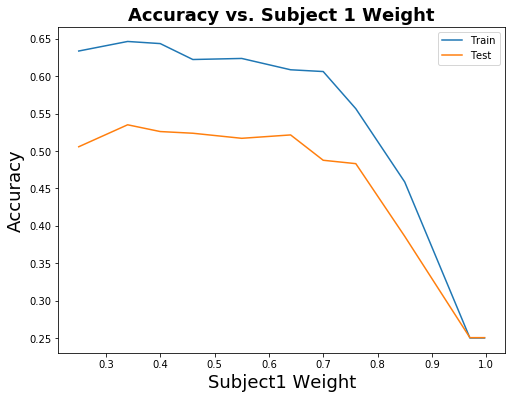

In [15]:
subject1_weight = [i[0] for i in W]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(subject1_weight, weight_train_acc, label = 'Train')
ax.plot(subject1_weight, weight_test_acc, label = 'Test')
ax.legend()
ax.set_title('Accuracy vs. Subject 1 Weight',fontweight="bold", size=18) # Title
ax.set_ylabel('Accuracy', fontsize = 18) # Y label
ax.set_xlabel('Subject1 Weight', fontsize = 18) # X label

# More Complicated Structure

In [16]:
class CNN_6layer(nn.Module):
    def __init__(self):
        super(CNN_6layer, self).__init__()
        self.conv1 = nn.Conv1d(in_channels = 22, out_channels = 64, kernel_size = 3)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(3)

        self.conv2 = nn.Conv1d(in_channels = 64, out_channels = 128, kernel_size = 7)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(3)

        self.conv3 = nn.Conv1d(in_channels = 128, out_channels = 256, kernel_size = 7)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(3)

        self.conv4 = nn.Conv1d(in_channels = 256, out_channels = 512, kernel_size = 7)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(3)

        self.conv5 = nn.Conv1d(in_channels = 512, out_channels = 1024, kernel_size = 7)
        self.bn5 = nn.BatchNorm1d(1024)
        self.pool5 = nn.AvgPool1d(3)

        self.dropout = nn.Dropout(0.6)
        self.fc1 = nn.Linear(1024, 4)

    def forward(self, x):
        x = x.to(device)
        # layer 1
        x = self.pool1(self.dropout(F.relu(self.bn1(self.conv1(x)))))

        # layer 2
        x = self.pool2(self.dropout(F.relu(self.bn2(self.conv2(x)))))

        # layer 3
        x = self.pool3(self.dropout(F.relu(self.bn3(self.conv3(x)))))

        # layer 4
        x = self.pool4(self.dropout(F.relu(self.bn4(self.conv4(x)))))

        # layer 5
        x = self.pool5(self.dropout(F.relu(self.bn5(self.conv5(x)))))


        # fc layer
        x = x.view(-1, 1024)
        x = self.fc1(x)

        return x

In [17]:
net2 = CNN_6layer()
net2.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net2.parameters(), lr = 0.001, momentum=0.9, weight_decay = 0.1)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

for epoch in range(500):
    running_loss = 0.0

    for mini_batch, d in enumerate(train_loader,0):
        # retreive data from data loader 
        inputs, labels = d
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)

        # train
        optimizer.zero_grad()
        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print
        running_loss += loss.item()
        if mini_batch % 10 == 9:
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            _, _, _, val_acc = acc(valid_loader, net2)
            print('[epoch %d, mini-batch %5d] loss: %.3f, train_acc: %d %%, val_acc: %d %%' %
                  (epoch + 1, mini_batch + 1, running_loss / 10, 100 * correct / len(labels), 100 * val_acc))
            running_loss = 0.0

val_label2, val_predict2, val_f12, val_acc2 = acc(valid_loader, net2)
test_label2, test_predict2, test_f12, test_acc2 = acc(test_loader, net2)
print('Training complete! Val acc: %d %%'%(val_acc2*100))
print('Training complete! Test acc: %d %%'%(test_acc2*100))

al_acc: 31 %
[epoch 366, mini-batch    20] loss: 0.442, train_acc: 95 %, val_acc: 33 %
[epoch 367, mini-batch    10] loss: 0.406, train_acc: 93 %, val_acc: 31 %
[epoch 367, mini-batch    20] loss: 0.412, train_acc: 98 %, val_acc: 31 %
[epoch 368, mini-batch    10] loss: 0.419, train_acc: 98 %, val_acc: 31 %
[epoch 368, mini-batch    20] loss: 0.443, train_acc: 89 %, val_acc: 30 %
[epoch 369, mini-batch    10] loss: 0.401, train_acc: 89 %, val_acc: 33 %
[epoch 369, mini-batch    20] loss: 0.420, train_acc: 95 %, val_acc: 33 %
[epoch 370, mini-batch    10] loss: 0.399, train_acc: 95 %, val_acc: 32 %
[epoch 370, mini-batch    20] loss: 0.415, train_acc: 96 %, val_acc: 32 %
[epoch 371, mini-batch    10] loss: 0.424, train_acc: 95 %, val_acc: 30 %
[epoch 371, mini-batch    20] loss: 0.457, train_acc: 93 %, val_acc: 34 %
[epoch 372, mini-batch    10] loss: 0.453, train_acc: 95 %, val_acc: 31 %
[epoch 372, mini-batch    20] loss: 0.456, train_acc: 98 %, val_acc: 28 %
[epoch 373, mini-batch   

In [18]:
class CNN_6layer_3fc(nn.Module):
    def __init__(self):
        super(CNN_6layer_3fc, self).__init__()
        self.conv1 = nn.Conv1d(in_channels = 22, out_channels = 64, kernel_size = 3)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(3)

        self.conv2 = nn.Conv1d(in_channels = 64, out_channels = 128, kernel_size = 7)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(3)

        self.conv3 = nn.Conv1d(in_channels = 128, out_channels = 256, kernel_size = 7)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(3)

        self.conv4 = nn.Conv1d(in_channels = 256, out_channels = 512, kernel_size = 7)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(3)

        self.conv5 = nn.Conv1d(in_channels = 512, out_channels = 1024, kernel_size = 7)
        self.bn5 = nn.BatchNorm1d(1024)
        self.pool5 = nn.AvgPool1d(3)

        self.dropout = nn.Dropout(0.6)
        self.fc1 = nn.Linear(1024, 2048)
        self.fc2 = nn.Linear(2048, 4)
        # self.fc3 = nn.Linear(4096,4)

    def forward(self, x):
        x = x.to(device)
        # layer 1
        x = self.pool1(self.dropout(F.relu(self.bn1(self.conv1(x)))))

        # layer 2
        x = self.pool2(self.dropout(F.relu(self.bn2(self.conv2(x)))))

        # layer 3
        x = self.pool3(self.dropout(F.relu(self.bn3(self.conv3(x)))))

        # layer 4
        x = self.pool4(self.dropout(F.relu(self.bn4(self.conv4(x)))))

        # layer 5
        x = self.pool5(self.dropout(F.relu(self.bn5(self.conv5(x)))))


        # fc layer
        x = x.view(-1, 1024)
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc2(x)

        return x

In [19]:
net3 = CNN_6layer_3fc()
net3.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net3.parameters(), lr = 0.0008, momentum=0.9, weight_decay = 0.1)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

for epoch in range(500):
    running_loss = 0.0

    for mini_batch, d in enumerate(train_loader,0):
        # retreive data from data loader 
        inputs, labels = d
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)

        # train
        optimizer.zero_grad()
        outputs = net3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print
        running_loss += loss.item()
        if mini_batch % 10 == 9:
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            _, _, _, val_acc = acc(valid_loader, net3)
            print('[epoch %d, mini-batch %5d] loss: %.3f, train_acc: %d %%, val_acc: %d %%' %
                  (epoch + 1, mini_batch + 1, running_loss / 10, 100 * correct / len(labels), 100 * val_acc))
            running_loss = 0.0

val_label3, val_predict3, val_f13, val_acc3 = acc(valid_loader, net3)
test_label3, test_predict3, test_f13, test_acc3 = acc(test_loader, net3)
print('Training complete! Val acc: %d %%'%(val_acc3*100))
print('Training complete! Test acc: %d %%'%(test_acc3*100))

n_acc: 51 %, val_acc: 26 %
[epoch 366, mini-batch    20] loss: 1.077, train_acc: 45 %, val_acc: 27 %
[epoch 367, mini-batch    10] loss: 1.079, train_acc: 53 %, val_acc: 28 %
[epoch 367, mini-batch    20] loss: 1.080, train_acc: 54 %, val_acc: 28 %
[epoch 368, mini-batch    10] loss: 1.081, train_acc: 45 %, val_acc: 28 %
[epoch 368, mini-batch    20] loss: 1.076, train_acc: 51 %, val_acc: 29 %
[epoch 369, mini-batch    10] loss: 1.080, train_acc: 56 %, val_acc: 26 %
[epoch 369, mini-batch    20] loss: 1.092, train_acc: 53 %, val_acc: 26 %
[epoch 370, mini-batch    10] loss: 1.088, train_acc: 46 %, val_acc: 27 %
[epoch 370, mini-batch    20] loss: 1.073, train_acc: 56 %, val_acc: 28 %
[epoch 371, mini-batch    10] loss: 1.070, train_acc: 57 %, val_acc: 27 %
[epoch 371, mini-batch    20] loss: 1.088, train_acc: 53 %, val_acc: 26 %
[epoch 372, mini-batch    10] loss: 1.079, train_acc: 57 %, val_acc: 28 %
[epoch 372, mini-batch    20] loss: 1.085, train_acc: 42 %, val_acc: 27 %
[epoch 373,

In [20]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size = 3)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size = 3, padding=2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        x = x.to(device)
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, num_classes=4):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv = nn.Conv1d(22, 64, kernel_size=3)
        self.bn = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 256)
        self.layer2 = self.make_layer(block, 1024,)
        self.fc = nn.Linear(1021952, 4)
        
    def make_layer(self, block, out_channels, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                nn.Conv1d(self.in_channels, out_channels, stride=stride, kernel_size = 1),
                nn.BatchNorm1d(out_channels))
        layers = block(self.in_channels, out_channels, stride, downsample)
        self.in_channels = out_channels
        return layers
    
    def forward(self, x):
        x = x.to(device)
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
model = ResNet(ResidualBlock, [0, 0]).to(device)

In [34]:
net4 = ResNet(ResidualBlock)
net4.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net4.parameters(), lr = 0.0008, momentum=0.9, weight_decay=0.5)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

for epoch in range(20):
    running_loss = 0.0

    for mini_batch, d in enumerate(train_loader,0):
        # retreive data from data loader 
        inputs, labels = d
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)

        # train
        optimizer.zero_grad()
        outputs = net4(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print
        running_loss += loss.item()
        if mini_batch % 10 == 9:
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            _, _, _, val_acc = acc(valid_loader, net4)
            print('[epoch %d, mini-batch %5d] loss: %.3f, train_acc: %d %%, val_acc: %d %%' %
                  (epoch + 1, mini_batch + 1, running_loss / 10, 100 * correct / len(labels), 100 * val_acc))
            running_loss = 0.0

val_label4, val_predict4, val_f14, val_acc4 = acc(valid_loader, net4)
test_label4, test_predict4, test_f14, test_acc4 = acc(test_loader, net4)
print('Training complete! Val acc: %d %%'%(val_acc4*100))
print('Training complete! Test acc: %d %%'%(test_acc4*100))

[epoch 1, mini-batch    10] loss: 35.009, train_acc: 21 %, val_acc: 27 %
[epoch 1, mini-batch    20] loss: 23.320, train_acc: 25 %, val_acc: 24 %
[epoch 2, mini-batch    10] loss: 8.238, train_acc: 31 %, val_acc: 29 %
[epoch 2, mini-batch    20] loss: 5.374, train_acc: 39 %, val_acc: 30 %
[epoch 3, mini-batch    10] loss: 1.449, train_acc: 68 %, val_acc: 31 %
[epoch 3, mini-batch    20] loss: 1.348, train_acc: 68 %, val_acc: 34 %
[epoch 4, mini-batch    10] loss: 0.544, train_acc: 84 %, val_acc: 34 %
[epoch 4, mini-batch    20] loss: 0.497, train_acc: 87 %, val_acc: 36 %
[epoch 5, mini-batch    10] loss: 0.279, train_acc: 90 %, val_acc: 34 %
[epoch 5, mini-batch    20] loss: 0.300, train_acc: 93 %, val_acc: 38 %
[epoch 6, mini-batch    10] loss: 0.211, train_acc: 98 %, val_acc: 37 %
[epoch 6, mini-batch    20] loss: 0.210, train_acc: 100 %, val_acc: 37 %
[epoch 7, mini-batch    10] loss: 0.186, train_acc: 98 %, val_acc: 41 %
[epoch 7, mini-batch    20] loss: 0.215, train_acc: 100 %, va

# Number of Epochs

In [25]:
time_train_acc, time_val_acc, time_test_acc = [], [], []
epochs = [1, 2, 5, 7, 10, 50, 100, 150, 200, 250, 300]
for epoch in epochs:
    net0 = CNN_trail()
    net0.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net0.parameters(), lr = 0.0001, momentum=0.9, weight_decay = 0.1)
    running_loss = 0.0

    for i in range(epoch):
        for mini_batch, d in enumerate(train_loader,0):
            # retreive data from data loader 
            inputs, labels = d
            inputs = inputs.float()
            inputs, labels = inputs.to(device), labels.to(device)

            # train
            optimizer.zero_grad()
            outputs = net0(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print
            running_loss += loss.item()
            if mini_batch % 10 == 9:
                _, predicted = torch.max(outputs, 1)
                correct = (predicted == labels).sum().item()
                _, _, _, val_acc = acc(valid_loader, net0)
                print('[epoch %d, mini-batch %5d] loss: %.3f, train_acc: %d %%, val_acc: %d %%' %
                    (i + 1, mini_batch + 1, running_loss / 10, 100 * correct / len(labels), 100 * val_acc))
                running_loss = 0.0

    _, _, _, train_acc0 = acc(train_val_loader, net0)
    _, _, _, val_acc0 = acc(valid_loader, net0)
    _, _, _, test_acc0 = acc(test_loader, net0)
    time_train_acc.append(train_acc0)
    time_val_acc.append(val_acc0)
    time_test_acc.append(test_acc0)
    print('Training complete! Val acc: %d %%'%(val_acc0*100))
    print('Training complete! Test acc: %d %%'%(test_acc0*100))

n_acc: 89 %, val_acc: 57 %
[epoch 166, mini-batch    20] loss: 0.549, train_acc: 85 %, val_acc: 55 %
[epoch 167, mini-batch    10] loss: 0.989, train_acc: 82 %, val_acc: 54 %
[epoch 167, mini-batch    20] loss: 0.589, train_acc: 78 %, val_acc: 56 %
[epoch 168, mini-batch    10] loss: 0.948, train_acc: 90 %, val_acc: 55 %
[epoch 168, mini-batch    20] loss: 0.565, train_acc: 82 %, val_acc: 54 %
[epoch 169, mini-batch    10] loss: 0.940, train_acc: 84 %, val_acc: 56 %
[epoch 169, mini-batch    20] loss: 0.549, train_acc: 85 %, val_acc: 56 %
[epoch 170, mini-batch    10] loss: 0.990, train_acc: 71 %, val_acc: 55 %
[epoch 170, mini-batch    20] loss: 0.547, train_acc: 92 %, val_acc: 56 %
[epoch 171, mini-batch    10] loss: 0.931, train_acc: 92 %, val_acc: 55 %
[epoch 171, mini-batch    20] loss: 0.580, train_acc: 79 %, val_acc: 57 %
[epoch 172, mini-batch    10] loss: 0.968, train_acc: 81 %, val_acc: 55 %
[epoch 172, mini-batch    20] loss: 0.572, train_acc: 93 %, val_acc: 53 %
[epoch 173,

Text(0,0.5,'Accuracy')

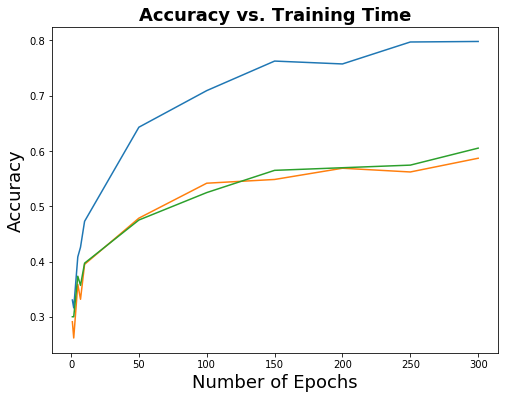

In [31]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(epochs, time_train_acc, label = 'Training Acc')
plt.plot(epochs, time_test_acc, label = 'Testing Acc')
plt.plot(epochs, time_val_acc, label = 'Validation Acc')
ax.set_title('Accuracy vs. Training Time',fontweight="bold", size=18) # Title
plt.xlabel('Number of Epochs', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)